In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import random 
import warnings

In this notebook we use the Python implementation of DESeq2, pydeseq2 to estimate differentially expressed genes between different conditions. In our dataset we do not have any replicates within a condition, so we create pseudoreplicates though this is the suboptimal variant. We pseudobulk the replicates through summation of gene counts and run pydeseq2 considering the main covariate, the condition. Finally, we generate gene lists from the DE tables to export for enrichment analysis.

In [3]:
def subset_data(alldata, groups, obs): 
    """
    Subset Anndata to relevant samples for DE contrast

    Args: 
        alldata (Anndata object): concatenated data with Leiden clustering and cell type annotation labels in .obs with all 
        genes, not only HVGs
        groups (list): list of sample or cell type name (s) as strings, to subset
        obs (str): which .obs column to subset at
    Returns: 
        Anndata object: Copy of alldata, subset to the samples/cell type, with filtered lowly expressed genes 
    """
    new_alldata = alldata[alldata.obs[obs].isin(groups),:].copy()
    sc.pp.filter_genes(new_alldata, min_cells = 10) # Filter out lowly expressed genes due to removal of large amount of cells
    return new_alldata


In [4]:
alldata = sc.read_h5ad('new_data/annotated/alldata.h5ad') # comes with raw counts as .X
alldata.var.index = alldata.var["gene_name"]
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata_backup1=alldata.copy()


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In order to make a DE contrast we subset the data only to the conditions of interest which will be compared.

In [5]:
alldata=alldata_backup1.copy()
samples=['20_nM_RA', '5000_nM_RA']
alldata=subset_data(alldata, samples, 'sample')


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
alldata

We performed DE between certain conditions within specific cell types. Sometimes we merged similar cell types for the sake of comparing two conditions.

In [6]:
# sometimes may be needed to rename or merge cell type labels for the sake of a DE contrast
mask = alldata.obs["manual_celltype_annotation"].isin(
    ["Differentiating\nNeurons", "Neural\nProgenitors"]
)
alldata.obs.loc[mask, "manual_celltype_annotation"] = "Neurons"

We also create plots visualising the DE groups on the embedding. Viewing the certain conditions separately sometimes is useful and helps to uncover previously unnoticeable cell abundancies in some clusters for these conditions

In [ ]:
def plot(alldata, groups, obs, label):
    '''
    This function first creates plots to visualise the two conditions in the data with all their cell types on the UMAP embedding and then the two 
    conditions within only the cell type of interest. This is to decide if there are enough cells and if the DE groups are balanced 
    (e.g. condition 1 does not have much more cells in the cell type of interest).

    Args:
        alldata (Anndata object): data with raw counts in .X for pydeseq2, subset to first level subset
        groups (list): list of str, groups compared in a DE contrast. Groups[0] is first in the contrast
        obs (str): name of .obs column to visualise
        label (None or str): the cell type or cluster the comparison is made in.
    Returns:
        pd.DataFrame with DE results and does not export it as a file
    '''
    fig, ax = plt.subplots(figsize=(4,3))
    sc.pl.umap(alldata, color=[obs], ax=ax, show=False)
    ax.set_title(f'{groups[0]} vs {groups[1]}', fontsize=12, weight='bold')
    if label is not None:
        ax.set_title(f'{label}\n{groups[0]} vs {groups[1]}', fontsize=12, weight='bold')
        filename=f'{groups[0]}-{groups[1]}_{label.replace("\n", "_")}.png'
    else:
        filename=f'{groups[0]}-{groups[1]}'
    plt.savefig(new_data/plots/de/filename, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
plot(alldata, samples, 'sample', 'Neurons')

balancing_subset() covers the case where cells have differing representions by the corresponding conditions

In [ ]:
def balancing_subset(cell_subset, groups): 
    '''
    This function subsets the larger group of cells such as to become equal to the smaller group and then filters out underexpressed genes.

    Args:
        cell_subset (Anndata_object): data subset to the groups. Should have normalised counts in .X for the sc.rank_genes_groups()
        groups (list): list of str, the groups to make balanced
    Returns:
        Anndata_object: copy of data object with balanced groups
    '''
    #how many cells the sample has in this obj
    cells = cell_subset.obs['sample'].value_counts()
    s1=groups[0]
    s2=groups[1]
    n_1 = cells[s1]
    n_2 = cells[s2]
    np.random.seed(42)
    #subset the larger sample such that it has equal amount cells to the other one
    keep_indices_1 = cell_subset.obs[cell_subset.obs['sample'] == s1].sample(n=n_2).index
    keep_indices_2 = cell_subset.obs[cell_subset.obs['sample'] == s2].index
    k = list(keep_indices_2) +list(keep_indices_1)
    #get the final obj
    balanced_subset = cell_subset[cell_subset.obs_names.isin(k), :].copy()
    #filter out underrepresented genes
    sc.pp.filter_genes(balanced_subset,min_cells=10)
    return balanced_subset.copy()

We subset the condition-subset object to a single cell type, optionally

In [7]:
cells=['Hematoendothelial\nProgenitors']
subset_data(alldata, cells, 'manual_celltype_annotation')

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [ ]:
cell_subset

Define the function that makes pseudoreplicates and pseudobulks. To make a pseudoreplicate, the data is subset one condition at a time. This condition can contain something like 5000 cells. These cells are randomly shuffled so that we ensure the pseudoreplicates have consistent representation of all the intrinsic variation in the condition. 

In [ ]:
# IMPORTANT: Code block by Sanbomics (GitHub: mousepixels), M. Sanbouw (2023). Docstring and modifications by mariakaraboeva, for readability
def pseudoreplicates(cell_subset, n, condition, labels, genes_var, batch_key=None):
    """
    Create pseudoreplicates, and pseudobulk them by summing all gene counts. This function creates pseudoreplicates on already subset Anndata 
    objects. 
    
    Args:
        cell_subset (Anndata object): Concatenated data subset to cell type and to condition of interest (by labels in .obs)
        n (int): number of replicates desired. Pseudoreplicates should have more than 200 cells each.
        condition (str): condition or any item in the data that comparison is done on, stored in .obs
        labels (str): any item the Anndata object is subset to and the compariosn is done within it; as stored in .obs
        genes_var (str or list): gene names or IDs as stored in .var for transfer to the new object
        batch_key (str): the batch .obs column, if present

    Returns:
        list: List of Anndata objects. Each of these objects represents one pseudobulk of one condition within the cell type of the input
        object. 

    """
    
    psreplicates_all_conds = []
    for c in cell_subset.obs[condition].unique(): # in cell subset eg celltype Neurons. Looking at indiv condition eg 20_nM_RA
        cond_cell_subset = cell_subset[cell_subset.obs[condition] == c] #Sometimes two cell types within one condition can be compared, if justified. 
        # then labels and condition variables can exchange meanings, e.g. put cell type .obs column name in place of condition and the condition .obs column name
        # in the labels slot
        
        # samp_cell_subset.X = samp_cell_subset.layers['counts'] #make sure to use raw data I use X as in the saved object which is raw
        
        indices = list(cond_cell_subset.obs_names) # so that pseudoreplicates are made containing random representation of the 
        #cells within a single sample to make the replicates
        random.seed(4)
        random.shuffle(indices)
        indices = np.array_split(np.array(indices), n) 
        
        for i, pseudo_rep in enumerate(indices): #i is the number of the partition of the single sample, so 1 2 or 3 in this case
        
            psrep_adata = sc.AnnData(X = cond_cell_subset[cond_cell_subset.obs_names.isin(pseudo_rep)].X.sum(axis = 0), var = cond_cell_subset.var[genes_var])
            psrep_adata.obs_names=[c+'_'+str(i)]
            psrep_adata.obs[condition] = c
            psrep_adata.obs['replicate'] = i
            if batch_key is not None:
                psrep_adata.obs[batch_key] = cond_cell_subset.obs[batch_key]
            psrep_adata.obs[labels]=cond_cell_subset.obs[labels]
            #one pseudoreplicate anndata always has 1 row
            psreplicates_all_conds.append(psrep_adata) # does not differentiate between the samples all samples in one place ...for one celltype however
    return psreplicates_all_conds

In [ ]:
psreplicates=pseudoreplicates(cell_subset)

In [ ]:
psreplicates

Obtain the final Anndata object containing pseudobulks; If 10 pseudoreplicates were made for a single condition, then an Anndata object with two conditions will have 20 "cells" and the original number of genes (e.g. 18000). 

In [ ]:
cells = sc.concat(psreplicates)
counts = pd.DataFrame(cells.X, columns = cells.var_names) #examine to see if raw counts, should be integers 

In [ ]:
counts

Here one can specify the design formula for the DE assessment or input a design matrix.
DESeq2 (here PyDESeq2) is an R Bioconductor package, originally developed for bulk RNAseq which robustly identifies DE genes by shrinking dispersion estimates, modulating this shrinking in relation to data specifities ultimately facilitating the sharing of information between genes to gain a global insight about the gene expression variation in the data. It models negatively binomial (raw) counts directly. To estimate the significance of the log2fold changes PyDESeq2 uses Wald tests.

In [ ]:
deseq_dataset = DeseqDataSet(
    counts = counts,
    metadata=cells.obs,
    design_factors='sample') # condition or a formula of covariates

Min cells=2 for underrepresented genes as the entire object has something like 20 cells.

In [ ]:
sc.pp.filter_genes(deseq_dataset, min_cells = 2) # no underrepresented genes which can have small variance

In [ ]:
deseq_dataset.deseq2()

Here we visualise if there is any difference of interest between these condition-derived pseudobulks prior to running DE analysis

In [ ]:
def pca(deseq_dataset, groups, label):
    '''
    Plot pseudobulks in PCA space

    Args:
        deseq_dataset (Anndata object): data with pseudobulks after processing by DESeq
        groups (list): list of str, the groups
        label (str): the cell type within which the compariosn is made
    '''
    sc.tl.pca(deseq_dataset)
    fig, ax = plt.subplots(figsize=(4,3))
    sc.pl.pca(deseq_dataset, color = 'sample', size = 200, ax=ax, show=False) 
    ax.set_title(f'{label} {groups[0]} vs {groups[1]}', fontsize=12, weight='bold')
    plt.savefig(f'new_data/plots/de/{label.str_replace('\n', '_')}_{groups[0]}-{groups[1].png', dpi=300, bbox_inches='tight')
    plt.show()

This outputs the final DE results which include log2fold changes and adjusted p-values for multiple testing.

In [ ]:
de_stats = DeseqStats(deseq_dataset, n_cpus=8, contrast=('sample', 'Mesoderm', 'Neural\nProgenitors'))

de_stats.summary()

In [ ]:
df_stats = de_stats.results_df

Some genes can have too little variance to have an estimate of padj and they can be removed but ideally they are not present

In [ ]:
df_stats = df_stats.dropna(subset=["padj"]) 

Sort the genes by their rank estimated by pydeseq2

In [ ]:
df_stats=df_stats.sort_values('stat', ascending = False)

In [ ]:
df_stats.isna().sum()

Export the DE genes dataframe

In [ ]:
df_stats.to_csv('new_data/tables/df_stats.csv')

In [2]:
def get_stats(t_stats):
    # code snippet available in Annotation.ipynb
    epsilon = 1e-300
    t_stats['pvals_adj'] = t_stats['pvals_adj'].replace(0, epsilon)
    t_stats['rank']=-np.log10(t_stats.pvals_adj)*t_stats.logfoldchanges
    t_stats = t_stats.sort_values('logfoldchanges', ascending=False)
    t_stats.reset_index(inplace=True)
    return t_stats
balanced_subset=balancing_subset(cell_subset, sample_list)
balanced_subset

def scanpy_de(alldata_subset, obs, groups, unbalanced=False):
    '''
    Perform DE with scanpy rank_genes_groups (not generally recommended)
    Args:
        alldata_subset (Anndata object): the subset object which can be either the output of balancing_subset() or not
        obs (str): the name of the .obs slot the conditions are stored in
        groups (list): list of str, the conditions being compared

    Returns:
        pd.DataFrame: the output dataframe of sc.rank_genes_groups()
        
    '''
    if unbalanced:
        alldata_subset=balancing_subset(cell_subset, groups)
    sc.tl.rank_genes_groups(alldata_subset, groupby=obs, method='t-test_overestim_var', key_added='t-test_overestim_var')
    de_result = sc.get.rank_genes_groups_df(alldata_subset, group=None, key="t-test_overestim_var")
    for c in groups:
        df=de_result[de_result[obs] == c]
        df=(get_stats(df))
        df.to_csv(f'new_data/tables/t-test_{c}-{groups[0]}-{groups[1]}.csv')
    return de_result
        


Import gene lists of interest to make heatmaps

In [ ]:
# gene_lists=pd.read_csv('new_data/tables/gene_lists.csv') 

The type of heatmap made here is useful as it visualises the separate cells in the non-pseudobulked (still subset to conditions 
and/or cell type) dataset. Then it is possible to see if this gene with a high log2fold change for example, is expressed consistently in all cells or strongly in a subgroup of cells.

In [ ]:
def make_heatmaps(cell_subset, gene_lists, column, groups, label):
    '''
    This function makes heatmaps of DE genes of interest using the scanpy built-in pl.heatmap function. The gene lists should be in the same format
    as var_names (e.g. gene symbols) and all genes as present in the dataframe should be present also in the Anndata object.
    
    Args:
        cell_subset (Anndata object): The data which contains only the subset (e.g. celltype) in which the DE contrast of interest was made
        gene_lists (pd.DataFrame): Dataframe with custom gene lists of interest (usually plot significantly DE genes as it is not clear from the plots if 
        a gene is significant)
        column (str): column name to get from DataFrame which contains a single gene list of interest
        groups (str): the groups, .obs column in cell_subset which is compared in the heatmap e.g. the DE genes between the two conditions of the DE contrast
        label (str): The cell type/cluster or condition in which the DE contrast was performed
        
    Returns:
        None
    '''
    de_genes = gene_lists[column].dropna().tolist()
    sc.tl.dendrogram(cell_subset, groupby=obs)
    fig, ax = plt.subplots()
    p=sc.pl.heatmap(cell_subset, var_names=de_genes, groupby=groups, cmap='viridis', standard_scale='var', show=False)
    plt.title(f"{label}", weight='bold', fontsize=12)
    plt.savefig(f'new_data/plots/de/de_heatmap_{column}_{label.str_replace('\n', '_')}.png', dpi=300, bbox_inches='tight')
    plt.show()


There is also the option to create Venn diagrams to visualise overlaps of genesets between output DE genes of interest between 
contrasts

In [ ]:
from matplotlib_venn import venn2, venn3


In [ ]:
def venn(gene_lists, title):
    '''
    Create venn plots from dataframe with gene lists.
    Args:
        gene_lists (pd.DataFrame): Dataframe with 2 or 3 gene lists (gene lists do not have to be equal length). Ideally dataframe column names are
        meaningful for the sets.
    Returns:
        None
    '''
    sets=[]
    for column in gene_lists.columns:
        genes=set(gene_lists[column].dropna().tolist())
        sets.append(genes)
    if len(sets)==3:
        venn3(sets, set_labels=(gene_lists.columns[0].title(), gene_lists.columns[1].title(), gene_lists.columns[2].title()))
    if len(sets)==2:
        venn2(sets, set_labels=(gene_lists.columns[0].title(), gene_lists.columns[1].title()))
    plt.title('title', weight='bold', fontsize=12)
    plt.show()


A number of reasons why the following way of correcting confounding covariates is not a good practice.
If a DE gene is upregulated in the contrast that differs by protocol only (e.g. RA_7d vs EB_8d) and is even more upregulated in the contrast
that differs by both condition and protocol, this could separately be due to protocol and to condition respectively. But removing common genes 
between the two contrasts would flag this gene as protocol-affected only which means that it would be removed even though it could actually be
condition-affected. DE profiles have upregulated and downregulated genes, e.g. directionality. In addition many genes and gene modules are recycled between processes. Thus DE profiles cannot be compared simply by gene names and that is why most tools have internal mechanisms for modeling confounding covariates with design matrices which help isolate the confounding covariate from the covariate of interest.

In [ ]:
bc=pd.read_csv('RA_7d_eb8d-RA7d LIST EP.csv') # sample contrast DE result list of top 300 upregulated and 300 downregulated
#most significant genes of samples that differ only by protocol
bc.drop(columns='Unnamed: 0', inplace=True)
bc

In [ ]:
protocol=list(bc['0'])
protocol

In [ ]:
ac = pd.read_csv('5000_nM_RA_list_epiblast_eb8_5000.csv') # DE result top 300 upregulated and 300 downregulated
#most significant genes of samples that differ by both protocol and condition
ac.drop(columns='Unnamed: 0', inplace=True)
ac

In [ ]:
ac = ac[~ac['0'].isin(protocol)] # removing common significantly DE genes between the two contrasts
ac

In [ ]:
ac.to_csv('new_data/epiblast_5000-eb8_condition.csv')

We create volcano plots to visualise significant DE genes of a contrast. The genes with large absolute log fold changes and 
smaller singificant adjusted p-values usually spread higher and to the side (the volcano plot ahs two sides for over- and under- expressed genes) and some of the top markers can be labelled by names all of which is done by the following function.

In [156]:
import seaborn as sns
from adjustText import adjust_text # creates flexible text labels which do not overlap

In [18]:
FDR = 0.01
LOG_FOLD_CHANGE = 0.5

def volcano_plot_from_df(df, padj, gene_name, logfold, groups, label, label_top_n=10):
    """
    Volcano plot using an external DE results DataFrame. 
    Code block by: Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). 
    DOI: https://doi.org/10.1038/s41576-023-00586-w
    see "Single-cell best practices" book, openly available
    *also with input from Gen A.I. and modifications by M. K.
    
    Args:
        df: pandas DataFrame with at least 'logfoldchanges', 'pvals_adj', and 'gene' columns
        padj (str): column name with adjusted p-values
        gene_name (str): column name with gene names
        logfold (str): column name with log2fold changes
        groups (list): list of str, DE groups
        label (str): cell type with the DE groups
        label_top_n: number of top genes (by FDR) to label with names on the plot
    Returns:
        None
    """
    # oprionally remove some genes with the lowest p-values to improve visibility and get singificant genes
    df[pvals] = df[pvals].replace(0, 1e-300)
    df = df[df["-log10FDR"] < 250]
    df = df.copy()
    df["-log10FDR"] = -np.log10(df[pvals].astype(float))
    df["significant"] = (df[pvals] < FDR) & (abs(df[logfold]) > LOG_FOLD_CHANGE)


    fig, ax = plt.subplots(figsize=(4,4))
    sns.scatterplot(
        data=df,
        x=logfold,
        y="-log10FDR",
        hue="significant",
        palette={True: "#0D5E5D", False: "lightgrey"},
        legend=False,
        s=6,
        ax=ax,
        edgecolor='none'
    )

    # threshold lines
    ax.axhline(-np.log10(FDR), linestyle="--", color="gray", lw=0.5)
    ax.axvline(-LOG_FOLD_CHANGE, linestyle="--", color="gray", lw=0.5)
    ax.axvline(LOG_FOLD_CHANGE, linestyle="--", color="gray", lw=0.5)

    # label top n genes by significance 
    top_genes = df[df["significant"]].nsmallest(label_top_n, padj)
    texts=[]
    for _, row in top_genes.iterrows():
        txt=ax.text(
            row[logfold],
            row["-log10FDR"],
            row[gene_name],
            fontsize=7,
            ha='right' if row[logfold] < 0 else 'left',
            va='center'
        )
        texts.append(txt)
    ax.set_ylim(0, 300 + 300 * 0.05) #to improve visibility
    ax.set_xlim(-7, 7)
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.3))

    ax.set_xlabel("log2 Fold Change")
    ax.set_ylabel("-log10 padj")
    if title:
        ax.set_title(f'{groups[0]} vs {groups[1]}\n{label}', fontsize=12, weight='bold')
    # fig, ax = plt.subplots(figsize=(4,3))
    # sc.pl.umap(cell_subset, color=['sample'], ax=ax, show=False)
    # ax.set_title(f'20_nM_RA Mesoderm vs Neural Progenitors', fontsize=12, weight='bold')
    plt.savefig(f'new_data/plots/de/{groups[0]}-{groups[1]}_{label.replace('\n', '_')}.png', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.tight_layout()
    plt.show()

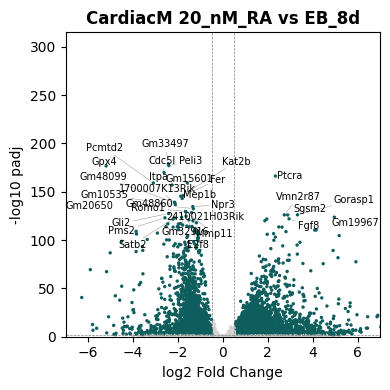

In [78]:
volcano_plot_from_df(a_c1, 'cardiac_meso',title="CardiacM 20_nM_RA vs EB_8d", label_top_n=30)

This function gets a dataframe of DE genes and isolates the significant ones based on thresholds and then can optionally
split the genes into highly and lowly expressed and save them as separate files (as is best for GO enrichment)

In [42]:

def go(filename, folder, high):
    """
    Extract significant genes for ORA analysis like GO enrichment
    Args:
        filename (str): the filename for the DE result table
        folder (str): folder name to save the final gene list
        high (bool): whether we want to extract the highly or the lowly expressed significant DE genes
    Returns:
        None
    """
    df = pd.read_csv(f'new_data/tables/{filename}') #or Tables/DE/{filename} for original results
    if high:
        mask = ((df['padj'] < FDR) & (abs(df['log2FoldChange'] > 0.5)) & (abs(df['log2FoldChange'] < 10)) & (df['baseMean']>=10))
    #     s='high'
    # else:
    #     mask = ((df['padj'] < FDR) & (df['log2FoldChange'] < -0.5) & (df['log2FoldChange'] > -10) & (df['baseMean']>=10))
    #     s='low'

    filtered_df = df[mask]
    filtered_df.to_csv(f'new_data/tables/{folder}/go_geneset.csv')
    return filtered_df

In [50]:
go('df_stats_HE_20nMvs5000_nM_RA.csv', 'gold_HE', True)

,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
25,Ncoa2,11.638665,4.567308,1.106870,4.126328,3.686011e-05,9.705765e-04
36,Rdh10,31.204093,1.169463,0.335834,3.482263,4.971948e-04,9.101065e-03
80,Cnnm3,20.108505,2.624459,0.523682,5.011547,5.399419e-07,2.380588e-05
92,Mgat4a,42.884882,1.189243,0.294127,4.043297,5.270468e-05,1.334817e-03
117,Gm8251,336.540782,0.938788,0.138434,6.781465,1.189633e-11,1.304762e-09
...,...,...,...,...,...,...,...
12936,Lman1l,99.709908,0.963327,0.204834,4.702967,2.564079e-06,9.196728e-05
12976,Gm40614,23.703808,3.536852,0.627231,5.638831,1.712081e-08,1.028101e-06
12980,1700027J07Rik,889.323975,2.347834,0.455160,5.158258,2.492583e-07,1.168872e-05
13112,Gm47920,116.144329,0.674763,0.187446,3.599777,3.184899e-04,6.308478e-03


In [2]:
df=go()

References:
1. Boris Muzellec, Maria Teleńczuk, Vincent Cabeli, Mathieu Andreux, PyDESeq2: a python package for bulk RNA-seq differential expression analysis, Bioinformatics, Volume 39, Issue 9, September 2023, btad547, https://doi.org/10.1093/bioinformatics/btad547
2. Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). https://doi.org/10.1038/s41576-023-00586-w
3. also see github.com/mousepixels for M. Sanbouw's implementation of DESeq2 and PyDESeq2